In [1]:
using CSV, DataFrames, Plots


In [2]:
module VCRO
using Random 
export VCRO_analog_component, frequency, update!, analog_output, reset!, Kvco_Hz, Kvco_rad

mutable struct VCRO_analog_component 
    stages::Int         # number of inverter stages
    tau0::Float64       # inverter delay
    Vcntrl::Function     # control voltage for ring oscillator
    dt::Float64         # time step
    t::Float64          # current time
    phase::Float64      # current phase in radians
end

# Constructor with random initial phase
function VCRO_analog_component(stages::Int, tau0::Float64, Vcntrl::Function, dt::Float64)
    initial_phase = 2*π*rand()
    VCRO_analog_component(stages, tau0, Vcntrl, dt, 0.0, initial_phase)
end

# Instanttaneous frequency
function frequency(vco::VCRO_analog_component)
    V = vco.Vcntrl(vco.t)
    τ = vco.tau0 / V
    return 1 / (2 * vco.stages * τ)
end

# Phase update (advance time and phase)
function update!(vco::VCRO_analog_component)
    f = frequency(vco)
    vco.phase += 2π * f * vco.dt
    vco.t += vco.dt
end

# Analog output: sine of the phase
analog_output(vco::VCRO_analog_component) = sin(vco.phase)

# Optional: reset simulation
function reset!(vco::VCRO_analog_component)
    vco.t = 0.0
    vco.phase = 2*π*rand()
end

# calculate Kvco
function Kvco_rad(vco::VCRO_analog_component)
    return π/(vco.stages * vco.tau0) # units: rad/s/V
end

function Kvco_Hz(vco::VCRO_analog_component)
    return 1 / (2 * vco.stages * vco.tau0) # units Hz/V
end

end


Main.VCRO

In [4]:
using .VCRO
using Plots

# Control voltage: constant or time-varying
Vcntrl(t) = 0.5 + 0.4 * sin(2π * 1e6 * t)  # Larger swing = more visible FM

# Create VCO component
dt = 1e-10
vco = VCRO.VCRO_analog_component(5, 1.0e-9, Vcntrl, dt)


VCRO_analog_component(5, 1.0e-9, Vcntrl, 1.0e-10, 0.0, 3.776829075816612)

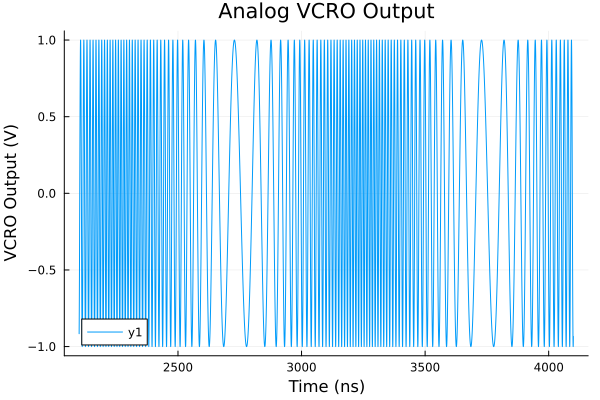

In [8]:

# Simulate
N = 20000
ts = zeros(N)
ys = zeros(N)

for i in 1:N
    ts[i] = vco.t
    ys[i] = VCRO.analog_output(vco)
    VCRO.update!(vco)
end

# Plot
plot(ts .* 1e9, ys, xlabel="Time (ns)", ylabel="VCRO Output (V)", title="Analog VCRO Output")